# Project work, part 2 - Data Sources

## Project Links

**Github Repository:** https://github.com/fayomitz/IND320-fayomitz  
**Streamlit app:** https://ind320-fayomitz.streamlit.app/

## AI Usage

Throughout this project, AI assistance (GitHub Copilot) was utilized in several key areas:

- **API Integration**: Assistance with understanding the Elhub API structure, handling timezone-aware datetime objects (pytz), and implementing the loop to fetch data month-by-month due to API limitations
- **Database Schema Design**: Help with designing the Cassandra table schema with appropriate primary keys (composite partition key with price_area and production_group) and clustering order for time-series data
- **Spark DataFrame Operations**: Guidance on column renaming, type conversion (timestamp handling), and proper Spark-Cassandra connector configuration
- **Data Visualization**: Creating professional matplotlib visualizations including pie charts with percentage labels and multi-line plots with proper legends and formatting
- **MongoDB Integration**: Assistance with document insertion, query operations, and verifying data integrity across collections
- **Code Documentation**: Writing detailed comments explaining each step, database operations, and data transformation logic
- **Streamlit Development**: Help with implementing the two-column layout, interactive widgets (radio buttons, pills, selectbox), and proper data caching strategies
- **Error Handling**: Adding try-catch blocks and user-friendly error messages for database connections and data operations

AI tools significantly improved development efficiency, code quality, and documentation clarity while maintaining full understanding of the data pipeline from API to visualization.

## Work Log

In this second assignment, I expanded the project by integrating multiple data sources and databases. The work involved setting up Cassandra and MongoDB databases, connecting to the Elhub API, processing large datasets, and creating interactive visualizations both locally and in the Streamlit app.

### Database Setup
I began by configuring Apache Cassandra locally and establishing a Spark-Cassandra connection. After verifying the connection with test data, I created a proper schema for storing energy production data with a composite primary key (price_area, production_group) and clustering by start_time for efficient time-series queries. In parallel, I set up a MongoDB Atlas account and tested the connection using PyMongo, ensuring I could perform CRUD operations from Python.

### API Data Retrieval
The main challenge was retrieving a full year of hourly production data from the Elhub API. I discovered that the API has time period limitations per request, so I implemented a loop that fetches data month-by-month for all of 2021. Timezone handling was critical - I used pytz to work with Norwegian time (Europe/Oslo) and properly handle summer/winter time transitions. The API returns nested JSON structures, so I carefully extracted only the productionPerGroupMbaHour lists from each response.

### Data Processing Pipeline
After collecting all API responses, I flattened the nested data structures and converted them to a pandas DataFrame. The data was then inserted into Cassandra using Spark, which required column renaming to match the database schema (camelCase to snake_case) and proper timestamp conversion. I used Spark's DataFrame API to read from Cassandra, selecting only the required columns (priceArea, productionGroup, startTime, quantityKwh) for further analysis and MongoDB storage. This approach demonstrated a complete ETL pipeline: Extract from API, Transform with Spark, Load into multiple database systems.

### Visualizations
For the Jupyter Notebook, I created two key visualizations. First, a pie chart showing the total yearly production distribution by production group for a chosen price area (NO1). This required grouping and aggregating data across the entire year. Second, a multi-line plot displaying hourly production trends for the first month, with separate lines for each production group. This involved careful datetime parsing and filtering, using matplotlib to create clear, professional visualizations with proper labels and legends.

### Streamlit App Enhancement
I updated the Streamlit app with a new page (page 4: Elhub Data) that connects directly to MongoDB using secrets management (keeping credentials secure). The page uses a two-column layout: the left column displays a pie chart for any selected price area using radio buttons, while the right column offers an interactive line plot where users can select production groups (via pills) and choose any month (via selectbox). This provides much more flexibility than the static notebook visualizations. I implemented proper caching with @st.cache_data and @st.cache_resource to optimize performance. Below the visualizations, an expander provides comprehensive documentation about the data source, API details, and field descriptions.

Throughout the project, I focused on code quality with detailed comments, proper error handling, and reproducible workflows. The integration of Cassandra, MongoDB, Spark, and Streamlit demonstrates a modern data engineering stack suitable for handling large-scale energy data analysis.

## Import Libraries and MongoDB Connection

This section imports all necessary Python libraries and establishes a connection to MongoDB Atlas using credentials stored in a `.env` file.

In [37]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import pytz
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from dotenv import load_dotenv
import os

load_dotenv()
uri = os.getenv("URI")  # Get MongoDB connection string from environment

# Create a new MongoDB client and connect to the server using the URI
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping command to confirm a successful connection
try:
    client.admin.command('ping')  # Test the connection
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


## Setup and test of Spark, MongoDB and Cassandra

In [38]:
# Set Hadoop home directory path (required for PySpark on Windows)
os.environ["HADOOP_HOME"] = "C:/Hadoop/hadoop-3.3.1"
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [39]:
# Import Cassandra cluster connection library
import asyncore
from cassandra.cluster import Cluster

# Create a Cassandra cluster connection to localhost on default port 9042
cluster = Cluster(['localhost'], port=9042)
# Establish a session for executing CQL queries
session = cluster.connect()

In [40]:
# Import Spark session for distributed data processing
from pyspark.sql import SparkSession

# Create or get existing Spark session with Cassandra connector configuration
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.5.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.
# If running this cell does not give any output after ~30 seconds, there is likely an error in the configuration (JAVA_HOME, HADOOP_HOME, etc.).

In [41]:
# Create a new table (first time only)
session.set_keyspace('my_first_keyspace')
session.execute("DROP TABLE IF EXISTS my_first_keyspace.my_first_table;") # Starting from scratch every time
session.execute("CREATE TABLE IF NOT EXISTS my_first_table (ind int PRIMARY KEY, company text, model text);")

In [42]:
session.execute("CREATE KEYSPACE IF NOT EXISTS my_first_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [43]:
# Insert some data (ind is the primary key, must be unique)
session.execute("INSERT INTO my_first_table (ind, company, model) VALUES (1, 'Tesla', 'Model S');")
session.execute("INSERT INTO my_first_table (ind, company, model) VALUES (2, 'Tesla', 'Model 3');")
session.execute("INSERT INTO my_first_table (ind, company, model) VALUES (3, 'Polestar', '3');")

In [44]:
# Query the data
rows = session.execute("SELECT * FROM my_first_table;")
for i in rows:
    print(i)

Row(ind=1, company='Tesla', model='Model S')
Row(ind=2, company='Tesla', model='Model 3')
Row(ind=3, company='Polestar', model='3')


In [45]:
session.execute_async("INSERT INTO my_first_table (ind, company, model) VALUES (5, 'Volkswagen', 'ID.3');")

<ResponseFuture: query='<SimpleStatement query="INSERT INTO my_first_table (ind, company, model) VALUES (5, 'Volkswagen', 'ID.3');", consistency=Not Set>' request_id=25 result=(no result yet) exception=None coordinator_host=None>

In [46]:
# Query the data
rows = session.execute("SELECT * FROM my_first_table;")
for i in rows:
    print(i)

Row(ind=5, company='Volkswagen', model='ID.3')
Row(ind=1, company='Tesla', model='Model S')
Row(ind=2, company='Tesla', model='Model 3')
Row(ind=3, company='Polestar', model='3')


In [47]:
# More specific query
prepared_statement = session.prepare("SELECT * FROM my_first_table WHERE company=? ALLOW FILTERING;")
teslas = session.execute(prepared_statement, ['Tesla'])
for i in teslas:
    print(i)

Row(ind=1, company='Tesla', model='Model S')
Row(ind=2, company='Tesla', model='Model 3')


In [48]:
# Selecting a database and a collection.
database = client['example']
collection = database['data']

In [49]:
# Inserting a single document (dictionary).
collection.insert_one({'name': 'Hallvard', 'age': 23})

# Inserting multiple documents (list of dictionaries).
collection.insert_many([
    {'name': 'Kristian', 'age': 27},
    {'name': 'Ihn Duck', 'age': 15}
])

# Note that an _id field is automatically generated by MongoDB.

In [50]:
# Reading ALL documents from a collection.
# ........................................

documents = collection.find({})
# A cursor is returned.

# The cursor can be iterated over:
for document in documents:
    print(document)

# Or directly converted to a list:
#documents = list(documents)

{'_id': ObjectId('68f24cb2a6f0e9d0a1f97b7f'), 'name': 'Hallvard Lavik', 'age': 34}
{'_id': ObjectId('68f24cb2a6f0e9d0a1f97b80'), 'name': 'Kristian', 'age': 38}
{'_id': ObjectId('68f24cb2a6f0e9d0a1f97b81'), 'name': 'Ihn Duck', 'age': 26}
{'_id': ObjectId('68f25da8d8698bfd0c7e6a7b'), 'name': 'Hallvard Lavik', 'age': 33}
{'_id': ObjectId('68f25da8d8698bfd0c7e6a7c'), 'name': 'Kristian', 'age': 37}
{'_id': ObjectId('68f25da8d8698bfd0c7e6a7d'), 'name': 'Ihn Duck', 'age': 25}
{'_id': ObjectId('68f9e1224e8c45d5ee0fb385'), 'name': 'Hallvard Lavik', 'age': 32}
{'_id': ObjectId('68f9e1224e8c45d5ee0fb386'), 'name': 'Kristian', 'age': 36}
{'_id': ObjectId('68f9e1224e8c45d5ee0fb387'), 'name': 'Ihn Duck', 'age': 24}
{'_id': ObjectId('68f9e24dd4c233458872dfec'), 'name': 'Hallvard Lavik', 'age': 31}
{'_id': ObjectId('68f9e24ed4c233458872dfed'), 'name': 'Kristian', 'age': 35}
{'_id': ObjectId('68f9e24ed4c233458872dfee'), 'name': 'Ihn Duck', 'age': 23}
{'_id': ObjectId('68f9e32c6dfbcb4154919b7f'), 'name'

In [51]:
# Reading SPECIFIC documents from a collection.
# .............................................

hallvard = collection.find({'name': 'Hallvard'})

for document in hallvard:
    print(document)

hallvard = list(hallvard)

{'_id': ObjectId('68fb4750eec11bd590684591'), 'name': 'Hallvard', 'age': 23}


In [52]:
# Updating a single document.
# ...........................
collection.update_one(
    {'name': 'Hallvard'},
    {'$set': {'name': 'Hallvard Lavik'}}  # Sets the `name` to `Hallvard Lavik`.
)

# Updating multiple documents.
# ............................
collection.update_many(
    {},
       {'$inc': {'age': 1}}  # Increments the `age` of all documents by `1`.
)

# Energy Data Pipeline

In [ ]:
headers = {
    
}

# API endpoint for energy production data by price area
base_url = "https://api.elhub.no/energy-data/v0/price-areas"
# Dataset identifier for hourly production data grouped by production type
dataset = "PRODUCTION_PER_GROUP_MBA_HOUR"

# Initialize timezone-aware datetime objects for Norwegian timezone (handles summer/winter time)
oslo_tz = pytz.timezone('Europe/Oslo')
start = oslo_tz.localize(datetime(2021, 1, 1, 0, 0, 0))  # Start: January 1, 2021
end = oslo_tz.localize(datetime(2021, 12, 31, 23, 59, 59))  # End: December 31, 2021

# List to store all API responses
responses = []

# Loop through the year month-by-month (API has time period limitations per request)
while start <= end:
    # Calculate the last moment of the current month
    month_end = (start.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(seconds=1)
    # Ensure we don't exceed the overall end date
    if month_end > end:
        month_end = end

    # Prepare query parameters for the API request
    params = {
        "dataset": dataset,
        "startDate": start.isoformat(),  # ISO format: YYYY-MM-DDTHH:MM:SS+TZ
        "endDate": month_end.isoformat()

    }

    response = requests.get(base_url, headers=headers, params=params)
    responses.append(response.json())

    start = month_end + timedelta(seconds=1)


In [70]:
# Extract all productionPerGroupMbaHour lists from all responses
all_production_data = []

# Iterate through each API response (one per month)
for response in responses:
    # Navigate through the response structure
    if 'data' in response:
        # Each response contains data for multiple price areas (NO1, NO2, NO3, NO4, NO5)
        for price_area in response['data']:
            # Navigate to the production data within the nested structure
            if 'attributes' in price_area and 'productionPerGroupMbaHour' in price_area['attributes']:
                production_list = price_area['attributes']['productionPerGroupMbaHour']
                # Only add non-empty lists to avoid null/empty entries
                if production_list:
                    # extend() flattens the list (adds individual records, not nested lists)
                    all_production_data.extend(production_list)

print(f"Total records extracted: {len(all_production_data)}")
print(f"Sample record: {all_production_data[0] if all_production_data else 'No data'}")

Total records extracted: 215353
Sample record: {'endTime': '2021-01-01T01:00:00+01:00', 'lastUpdatedTime': '2024-12-20T10:35:40+01:00', 'priceArea': 'NO1', 'productionGroup': 'hydro', 'quantityKwh': 2507716.8, 'startTime': '2021-01-01T00:00:00+01:00'}


In [ ]:
# Convert the list of dictionaries to a pandas DataFrame
# Each dictionary becomes a row, dictionary keys become column names
df = pd.DataFrame(all_production_data)
print(f"DataFrame shape: {df.shape}")
print(f"\nDataFrame columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

DataFrame shape: (215353, 6)

DataFrame columns: ['endTime', 'lastUpdatedTime', 'priceArea', 'productionGroup', 'quantityKwh', 'startTime']

First few rows:
                     endTime            lastUpdatedTime priceArea  \
0  2021-01-01T01:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
1  2021-01-01T02:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
2  2021-01-01T03:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
3  2021-01-01T04:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
4  2021-01-01T05:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   

  productionGroup  quantityKwh                  startTime  
0           hydro    2507716.8  2021-01-01T00:00:00+01:00  
1           hydro    2494728.0  2021-01-01T01:00:00+01:00  
2           hydro    2486777.5  2021-01-01T02:00:00+01:00  
3           hydro    2461176.0  2021-01-01T03:00:00+01:00  
4           hydro    2466969.2  2021-01-01T04:00:00+01:00  


In [56]:
# Drop the existing table if it exists (ensures clean schema)
session.execute("DROP TABLE IF EXISTS my_first_keyspace.production_data;")

# Create table with schema optimized for time-series queries
# Composite partition key (price_area, production_group) distributes data across nodes
# Clustering key (start_time) orders data within each partition for efficient time-range queries
create_table_query = """
CREATE TABLE IF NOT EXISTS my_first_keyspace.production_data (
    price_area text,
    production_group text,
    start_time timestamp,
    end_time timestamp,
    quantity_kwh double,
    last_updated_time timestamp,
    PRIMARY KEY ((price_area, production_group), start_time)
) WITH CLUSTERING ORDER BY (start_time ASC);
"""

session.execute(create_table_query)
print("Table 'production_data' created successfully!")

Table 'production_data' created successfully!


In [57]:
# Convert pandas DataFrame to Spark DataFrame for distributed processing
spark_df = spark.createDataFrame(df)

# Rename columns to match Cassandra table schema (convert camelCase to snake_case)
spark_df = spark_df.withColumnRenamed("priceArea", "price_area") \
                   .withColumnRenamed("productionGroup", "production_group") \
                   .withColumnRenamed("startTime", "start_time") \
                   .withColumnRenamed("endTime", "end_time") \
                   .withColumnRenamed("quantityKwh", "quantity_kwh") \
                   .withColumnRenamed("lastUpdatedTime", "last_updated_time")

# Import Spark SQL function for timestamp conversion
from pyspark.sql.functions import to_timestamp

# Convert string timestamp columns to proper timestamp data type
# This is required for Cassandra to correctly store and query time-series data
spark_df = spark_df.withColumn("start_time", to_timestamp("start_time")) \
                   .withColumn("end_time", to_timestamp("end_time")) \
                   .withColumn("last_updated_time", to_timestamp("last_updated_time"))

# Display transformed DataFrame information
print("Spark DataFrame schema:")
spark_df.printSchema()
print(f"\nTotal rows: {spark_df.count()}")
print("\nFirst few rows:")
spark_df.show(5, truncate=False)

Spark DataFrame schema:
root
 |-- end_time: timestamp (nullable = true)
 |-- last_updated_time: timestamp (nullable = true)
 |-- price_area: string (nullable = true)
 |-- production_group: string (nullable = true)
 |-- quantity_kwh: double (nullable = true)
 |-- start_time: timestamp (nullable = true)


Total rows: 215353

First few rows:

Total rows: 215353

First few rows:
+-------------------+-------------------+----------+----------------+------------+-------------------+
|end_time           |last_updated_time  |price_area|production_group|quantity_kwh|start_time         |
+-------------------+-------------------+----------+----------------+------------+-------------------+
|2021-01-01 01:00:00|2024-12-20 10:35:40|NO1       |hydro           |2507716.8   |2021-01-01 00:00:00|
|2021-01-01 02:00:00|2024-12-20 10:35:40|NO1       |hydro           |2494728.0   |2021-01-01 01:00:00|
|2021-01-01 03:00:00|2024-12-20 10:35:40|NO1       |hydro           |2486777.5   |2021-01-01 02:00:00|
|202

In [58]:
# Insert data into Cassandra using Spark
spark_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .mode("append") \
    .options(table="production_data", keyspace="my_first_keyspace") \
    .save()

print("Data successfully inserted into Cassandra!")

Data successfully inserted into Cassandra!


In [59]:
# Verify successful insertion by querying sample records from Cassandra
rows = session.execute("SELECT * FROM my_first_keyspace.production_data LIMIT 10;")
print("Sample data from Cassandra:")
for row in rows:
    print(row)

Sample data from Cassandra:
Row(price_area='NO3', production_group='wind', start_time=datetime.datetime(2020, 12, 31, 23, 0), end_time=datetime.datetime(2021, 1, 1, 0, 0), last_updated_time=datetime.datetime(2024, 12, 20, 9, 35, 40), quantity_kwh=259312.2)
Row(price_area='NO3', production_group='wind', start_time=datetime.datetime(2021, 1, 1, 0, 0), end_time=datetime.datetime(2021, 1, 1, 1, 0), last_updated_time=datetime.datetime(2024, 12, 20, 9, 35, 40), quantity_kwh=225762.9)
Row(price_area='NO3', production_group='wind', start_time=datetime.datetime(2021, 1, 1, 1, 0), end_time=datetime.datetime(2021, 1, 1, 2, 0), last_updated_time=datetime.datetime(2024, 12, 20, 9, 35, 40), quantity_kwh=248005.1)
Row(price_area='NO3', production_group='wind', start_time=datetime.datetime(2021, 1, 1, 2, 0), end_time=datetime.datetime(2021, 1, 1, 3, 0), last_updated_time=datetime.datetime(2024, 12, 20, 9, 35, 40), quantity_kwh=243180.3)
Row(price_area='NO3', production_group='wind', start_time=datetim

## Data Visualizations

Creating two key visualizations to analyze energy production patterns:
1. **Pie Chart**: Total yearly production distribution by production group for a selected price area
2. **Line Plot**: Hourly production trends for the first month, showing all production groups

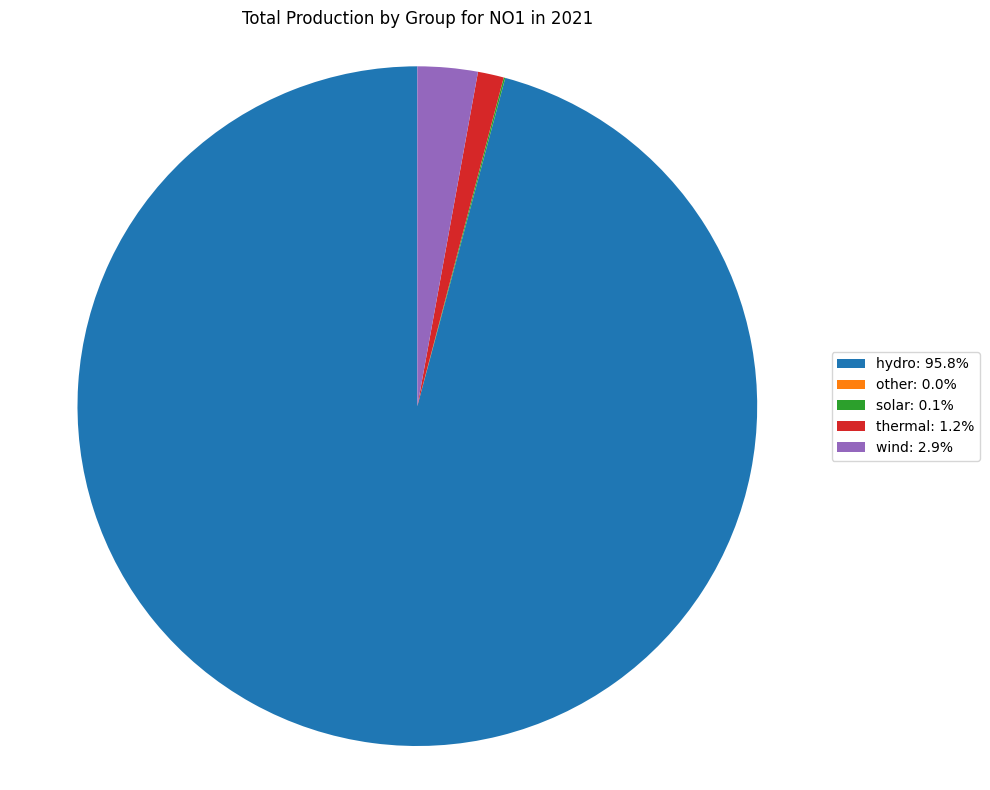

In [65]:
# Import matplotlib for creating visualizations
import matplotlib.pyplot as plt

# Select the price area to analyze (NO1 represents Southern Norway)
chosen_price_area = 'NO1'

# Filter the DataFrame to include only records from the chosen price area
price_area_data = df[df['priceArea'] == chosen_price_area]

# Aggregate production data: group by production type and sum all hourly values for the year
yearly_production = price_area_data.groupby('productionGroup')['quantityKwh'].sum()

# Calculate percentages for legend
total_production = yearly_production.sum()
percentages = (yearly_production / total_production * 100)

# Create labels with production group names and percentages
legend_labels = [f'{group}: {pct:.1f}%' for group, pct in zip(yearly_production.index, percentages)]

# Create a pie chart to show the distribution
plt.figure(figsize=(10, 8))
plt.pie(
    yearly_production,              # Data values
    labels=None,                    # No labels on the chart itself
    startangle=90                    # Start the first slice at 90 degrees (top)
)
plt.title(f'Total Production by Group for {chosen_price_area} in 2021')
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))  # Legend outside the plot
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

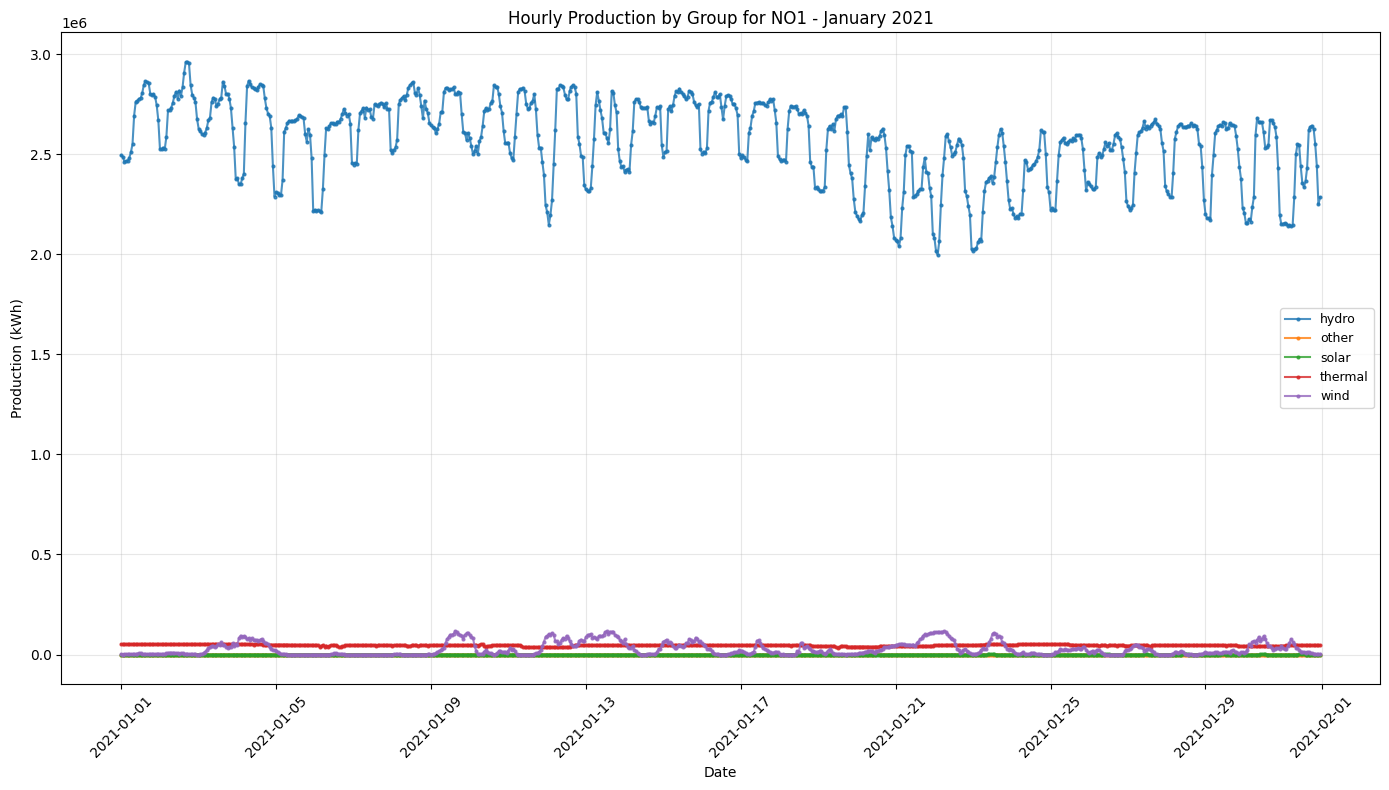


Number of records for NO1 in January 2021: 3720
Production groups: ['hydro' 'other' 'solar' 'thermal' 'wind']


In [ ]:
# Parse the startTime column to proper datetime objects
# utc=True handles mixed timezones consistently by converting to UTC
df['startTime_parsed'] = pd.to_datetime(df['startTime'], utc=True)

# Filter data for the chosen price area and January 2021
first_month_data = df[(df['priceArea'] == chosen_price_area) & 
                      (df['startTime_parsed'].dt.month == 1) & 
                      (df['startTime_parsed'].dt.year == 2021)]

# Create a large figure for better readability
plt.figure(figsize=(14, 8))

# Plot a separate line for each production group
for group in first_month_data['productionGroup'].unique():
    # Filter data for this specific production group
    group_data = first_month_data[first_month_data['productionGroup'] == group]
    # Sort by time to ensure the line connects points in chronological order
    group_data_sorted = group_data.sort_values('startTime_parsed')
    # Plot the time series with styled markers and lines
    plt.plot(
        group_data_sorted['startTime_parsed'],  # X-axis: time
        group_data_sorted['quantityKwh'],        # Y-axis: production in kWh
        label=group,                             # Legend label
        marker='o',                              # Circle markers at each data point
        markersize=2,                            # Small markers to avoid clutter
        linewidth=1.5,                           # Line thickness
        alpha=0.8                                # Slight transparency
    )

# Customize the plot appearance
plt.xlabel('Date')
plt.ylabel('Production (kWh)')
plt.title(f'Hourly Production by Group for {chosen_price_area} - January 2021')

plt.legend(loc='best', fontsize=9)  # Automatic legend placementprint(f"Production groups: {first_month_data['productionGroup'].unique()}")
plt.grid(True, alpha=0.3)           # Light grid for easier readingprint(f"\nNumber of records for {chosen_price_area} in January 2021: {len(first_month_data)}")
plt.xticks(rotation=45)             # Rotate x-axis labels for better readability# Print summary statistics
plt.tight_layout()                  # Prevent label overlap
plt.show()

# Print summary statistics
print(f"\nNumber of records for {chosen_price_area} in January 2021: {len(first_month_data)}")
print(f"Production groups: {first_month_data['productionGroup'].unique()}")

## Insert Data into MongoDB

Inserting the production data into MongoDB for flexible document-based querying and integration with the Streamlit app.

In [62]:
# Select MongoDB database and collection for production data
# This creates them automatically if they don't exist
production_db = client['energy_data']  # Database name
production_collection = production_db['production']  # Collection name

# Convert pandas DataFrame to a list of dictionaries (MongoDB documents)
# Each row becomes a document with field names from DataFrame columns
production_records = df.to_dict('records')

# Clear any existing data in the collection to avoid duplicates
production_collection.delete_many({})  # Empty filter {} deletes all documents

# Insert all production records into MongoDB in a single batch operation
result = production_collection.insert_many(production_records)

# Display insertion summary
print(f"Successfully inserted {len(result.inserted_ids)} documents into MongoDB!")
print(f"Database: energy_data")
print(f"Collection: production")

Successfully inserted 215353 documents into MongoDB!
Database: energy_data
Collection: production


In [63]:
# Query sample documents from MongoDB to verify insertion
sample_docs = production_collection.find().limit(5)  # Get first 5 documents

print("Sample documents from MongoDB:")
for doc in sample_docs:
    print(doc)  # Each document includes auto-generated _id field

# Count total documents in the collection
total_count = production_collection.count_documents({})  # Empty filter counts all
print(f"\nTotal documents in MongoDB: {total_count}")

# Get distinct values for the priceArea field to see all represented areas
unique_areas = production_collection.distinct('priceArea')
print(f"Unique price areas: {unique_areas}")

Sample documents from MongoDB:
{'_id': ObjectId('68fb47a1eec11bd590684594'), 'endTime': '2021-01-01T01:00:00+01:00', 'lastUpdatedTime': '2024-12-20T10:35:40+01:00', 'priceArea': 'NO1', 'productionGroup': 'hydro', 'quantityKwh': 2507716.8, 'startTime': '2021-01-01T00:00:00+01:00', 'startTime_parsed': datetime.datetime(2020, 12, 31, 23, 0)}
{'_id': ObjectId('68fb47a1eec11bd590684595'), 'endTime': '2021-01-01T02:00:00+01:00', 'lastUpdatedTime': '2024-12-20T10:35:40+01:00', 'priceArea': 'NO1', 'productionGroup': 'hydro', 'quantityKwh': 2494728.0, 'startTime': '2021-01-01T01:00:00+01:00', 'startTime_parsed': datetime.datetime(2021, 1, 1, 0, 0)}
{'_id': ObjectId('68fb47a1eec11bd590684596'), 'endTime': '2021-01-01T03:00:00+01:00', 'lastUpdatedTime': '2024-12-20T10:35:40+01:00', 'priceArea': 'NO1', 'productionGroup': 'hydro', 'quantityKwh': 2486777.5, 'startTime': '2021-01-01T02:00:00+01:00', 'startTime_parsed': datetime.datetime(2021, 1, 1, 1, 0)}
{'_id': ObjectId('68fb47a1eec11bd590684597'),